# Simulation 1

Vivek Gopalakrishnan | June 26, 2019


## Purpose

To determine if an edge is significantly different across 2 populations, should 
you use a T-test or a Wilcoxon signed-rank test?


## Setup

- In this experiment, we use the indpendent edge (IE) model. 
- According to this model, the weight of each edge is given by an independent
Bernoulli randomn variable, i.e. $\Pr{(A_{ij} = 1)} = p_{ij}$. 
- The matrix of all $p_{ij}$'s is called the P matrix.
- We generate two samples from different IE models. Each model has a
symmetric P matrix with the same shape (therefore, each simulated graph
has the same number of nodes).


## Simulation

### Procedure

1. Let 
$\mathbf{b}$ be a vector of length $n$ linearly 
increasing over the range $[\epsilon, 1-\epsilon]$.

2. Let 
$\mathbf{P_1}$ be a grid determined by $\mathbf{b}$, i.e. 
$\mathbf{P_1}(1,1) = \mathbf{b}_1, \mathbf{P_1}(1,2) = \mathbf{b}_2, ...$ .

3. Let 
$
\mathbf{P_2}(u,v) = \begin{cases} 
    \mathbf{P_1}(u,v) + \delta \hspace{6mm} \text{if} \hspace{2mm} \mathbf{P_1}(u,v) < 0.5 \\
    \mathbf{P_1}(u,v) - \delta \hspace{6mm} \text{if} \hspace{2mm} \mathbf{P_1}(u,v) \geq 0.5
\end{cases}
$

4. Sample
$X_i \stackrel{iid}{\sim} \text{IE}(\mathbf{P_1})$ and 
$Y_i \stackrel{iid}{\sim} \text{IE}(\mathbf{P_2})$
for $i=1,...,m$.

Notice that $\mathbf{P_1} \in \mathbb{R}^{n \times n}$ 
and $\mathbf{P_2} \in \mathbb{R}^{n \times n}$.


## Testing

For each edge $ij$, 
1. Use the T-test to test the null hypothesis $\text{mean}(X_{ij}) = \text{mean}(Y_{ij})$
2. Use the Wilcoxon signed-rank test to test the null hypothesis $\text{median}(X_{ij}) = \text{median}(Y_{ij})$

Plot the power versus $\mathbf{P}_{ij}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.utils import is_symmetric
from scipy.stats import ttest_ind, wilcoxon

from src.simulations import IndependentEdge

%matplotlib inline

## Fit the model

### Parameters
- Sample size: $m = 10$
- Number of vertices: $n = 10$
- $\epsilon = 0.001$
- $\delta = 0.05$

In [2]:
ie = IndependentEdge(sample_size=10, n_vertices=10, epsilon=0.001, delta=0.05)

## Visualize the parameters and data

Draw heatmaps of the matrices $\mathbf{P_1}$ and $\mathbf{P_2}$ 
and plot $\mathbf{P_2} - \mathbf{P_1}$.

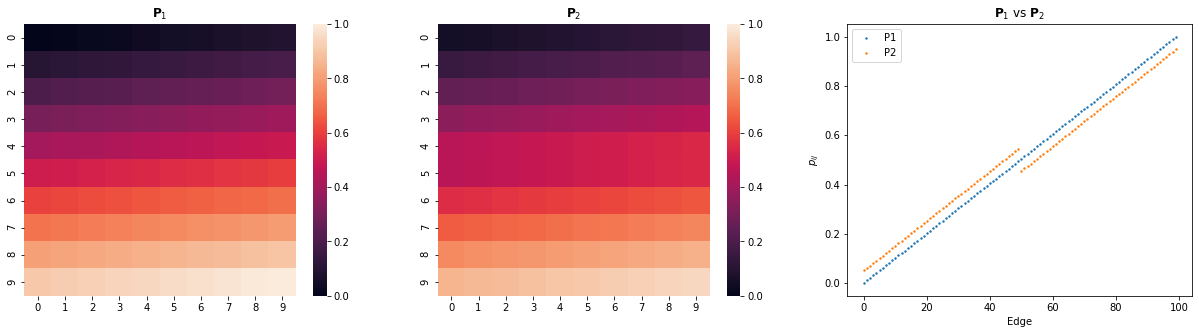

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(21, 5),)

# Draw the heatmaps
sns.heatmap(ie.p1, square=True, ax=ax[0], vmin=0, vmax=1)
sns.heatmap(ie.p2, square=True, ax=ax[1], vmin=0, vmax=1)
ax[0].set(title=r"$\mathbf{P}_1$")
ax[1].set(title=r"$\mathbf{P}_2$")

# Draw the scatterplot
y1 = ie.p1.flatten()
y2 = ie.p2.flatten()
x = range(len(y1))
ax[2].scatter(x, y1, label="P1", s=2)
ax[2].scatter(x, y2, label="P2", s=2)
ax[2].legend()
ax[2].set(title=r"$\mathbf{P}_1$ vs $\mathbf{P}_2$", xlabel="Edge", ylabel=r"$p_{ij}$")

plt.show()

Plot the average connectome for each population 
$\bar{\mathbf{X}}$ and $\bar{\mathbf{Y}}$.
Also plot $\bar{\mathbf{Y}} - \bar{\mathbf{X}}$

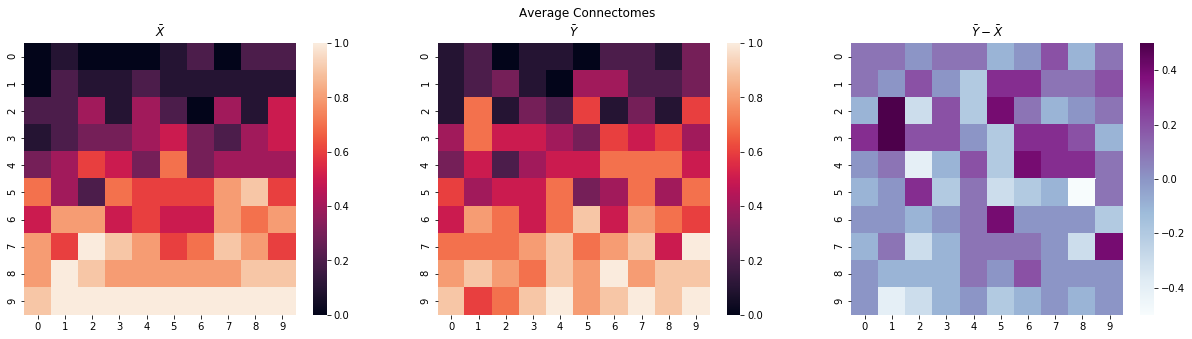

In [4]:
# Sample the graphs and calculate the average
x, y = ie._sample()
x = np.mean(x, axis=0)
y = np.mean(y, axis=0)

fig, ax = plt.subplots(ncols=3, figsize=(21, 5),)

sns.heatmap(x, square=True, ax=ax[0], vmin=0, vmax=1)
ax[0].set(title=r"$\bar{X}$")

sns.heatmap(y, square=True, ax=ax[1], vmin=0, vmax=1)
ax[1].set(title=r"$\bar{Y}$")

sns.heatmap(y - x, square=True, ax=ax[2], cmap="BuPu")
ax[2].set(title=r"$\bar{Y} - \bar{X}$")

fig.suptitle("Average Connectomes")
plt.show()

## Run the simulation

Run the simulation 1000 times to and store the proportion of iterations
that successfully rejected the null.

In [5]:
power = ie.calculate_power(ttest_ind, wilcoxon, n_iter=1000)

100%|██████████| 1000/1000 [00:48<00:00, 20.43it/s]


In [6]:
# Store the data in a Seaborn-compatible format
df = pd.DataFrame({
    r"$p_{ij}$": ie.p1.flatten(),
    "t-test": power[0].flatten(),
    "wilcoxon": power[1].flatten(),
}).melt(
    id_vars=[r"$p_{ij}$"], 
    value_vars=["t-test", "wilcoxon"],
    var_name="test", 
    value_name="power",
)

df.to_csv("results/m10_wilcoxon")
df.head()

,$p_{ij}$,test,power
0,0.001000,t-test,0.000
1,0.011081,t-test,0.002
2,0.021162,t-test,0.000
3,0.031242,t-test,0.005
4,0.041323,t-test,0.012


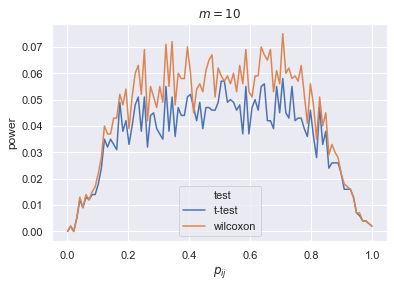

In [7]:
# Plot the power as a function of the connection strength
sns.set()
ax = sns.lineplot(x=r"$p_{ij}$", y="power", hue="test", data=df, legend="full")
ax.set_title(r"$m=10$")
plt.show()

## Increase the sample size and rerun the simulation
Change sample size to 100.

100%|██████████| 1000/1000 [00:54<00:00, 18.65it/s]


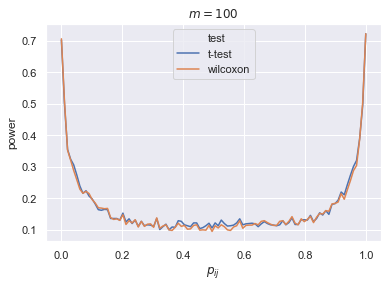

In [8]:
# Intialize the class
ie = IndependentEdge(sample_size=100, n_vertices=10, epsilon=0.001, delta=0.05)

# Run the test
power = ie.calculate_power(ttest_ind, wilcoxon, n_iter=1000)

# Store the data in a Seaborn-compatible format
df = pd.DataFrame({
    r"$p_{ij}$": ie.p1.flatten(),
    "t-test": power[0].flatten(),
    "wilcoxon": power[1].flatten(),
}).melt(
    id_vars=[r"$p_{ij}$"], 
    value_vars=["t-test", "wilcoxon"],
    var_name="test", 
    value_name="power",
)
df.to_csv("results/m100_wilcoxon")

# Plot the power curve
sns.set()
ax = sns.lineplot(x=r"$p_{ij}$", y="power", hue="test", data=df, legend="full")
ax.set_title(r"$m=100$")
plt.show()